# Understanding `solve_ivp` Parameters

Dive into the function arguments and how they influence the integration.

## `solve_ivp` Parameters
This notebook covers all the major parameters of `solve_ivp`, how they affect the solution, and when to use them.

## Required Parameters

The `solve_ivp` function requires the following arguments:

```python
solve_ivp(fun, t_span, y0)
```
- `fun(t, y)`: The ODE system as a Python function
- `t_span=(t0, tf)`: Tuple with initial and final times
- `y0`: Initial values (array-like)


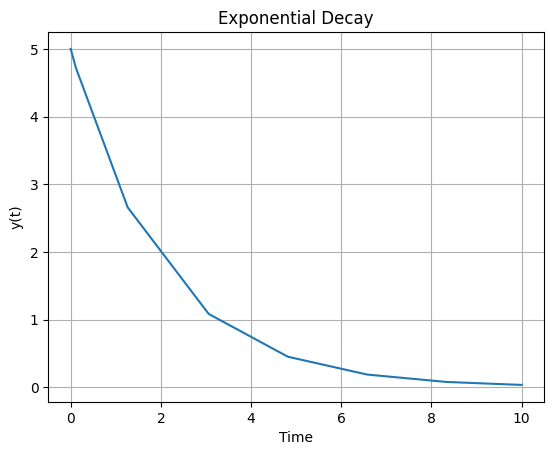

In [1]:
# Example: Simple exponential decay
def decay(t, y):
    return -0.5 * y

from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

sol = solve_ivp(decay, t_span=(0, 10), y0=[5])

plt.plot(sol.t, sol.y[0])
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Exponential Decay')
plt.grid(True)
plt.show()

## Optional Parameters

### `method`
Specifies the solver to use:
- `'RK45'` (default) – Explicit Runge-Kutta 5(4)
- `'RK23'` – Lower order, more conservative
- `'DOP853'` – High order, more accurate but slower
- `'Radau'`, `'BDF'` – For stiff problems
- `'LSODA'` – Automatically chooses stiff/non-stiff


### `t_eval`
Array of times at which to store the computed solution.
If not provided, solver chooses internal time steps adaptively.


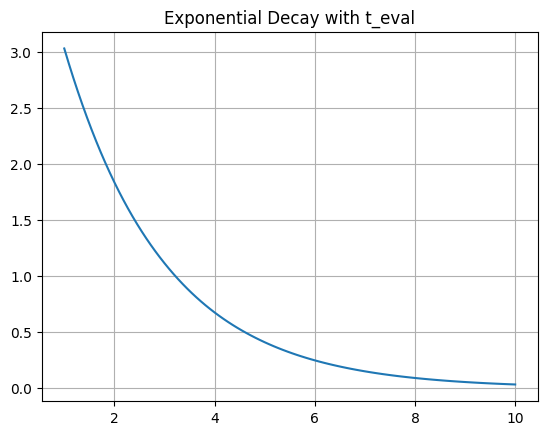

In [ ]:
# Example with t_eval
import numpy as np
sol = solve_ivp(decay, t_span=(0, 10), y0=[5], t_eval=np.linspace(0, 10, 100))

plt.plot(sol.t, sol.y[0])
plt.title('Exponential Decay with t_eval')
plt.grid(True)
plt.show()

### `rtol` and `atol`
- `rtol`: Relative tolerance (default: 1e-3)
- `atol`: Absolute tolerance (default: 1e-6)

Controls adaptive step size. Solver ensures:

$$
|error| \leq atol + rtol \cdot |y|
$$

Lower values = more accurate but slower.

Time: 0.0030035972595214844 sec
Time: 0.009996414184570312 sec


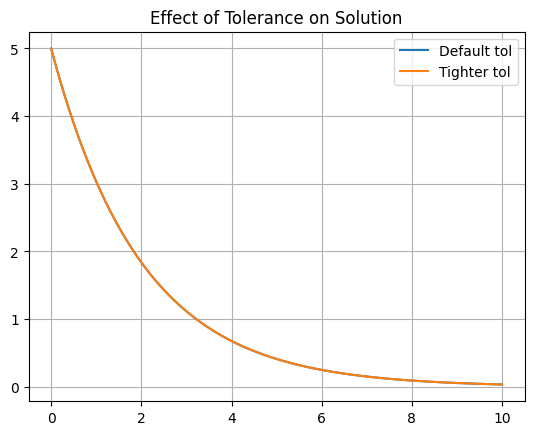

In [7]:
import time

# Comparison of tolerances
start_sol_1 = time.time()
sol1 = solve_ivp(decay, (0, 10), [5], rtol=1e-3, atol=1e-4, t_eval=np.linspace(0, 10, 100))
duration_sol_1 = time.time() - start_sol_1
print('Time:', duration_sol_1, 'sec')

start_sol_2 = time.time()
sol2 = solve_ivp(decay, (0, 10), [5], rtol=1e-6, atol=1e-7, t_eval=np.linspace(0, 10, 100))
duration_sol_2 = time.time() - start_sol_2
print('Time:', duration_sol_2, 'sec')

plt.plot(sol1.t, sol1.y[0], label='Default tol')
plt.plot(sol2.t, sol2.y[0], label='Tighter tol')
plt.legend()
plt.title('Effect of Tolerance on Solution')
plt.grid(True)
plt.show()

## `vectorized`

If `vectorized=True`, SciPy assumes ODE function `fun(t, y)` can accept a **2D array** `y` with shape **`(n, m)`**, where:
- `n` is the number of state variables
- `m` is the number of intermediate evaluations during a solver step

This allows the solver to call the function once with a batch of `m` columns (states), which can be much faster.

---

### What changes with `vectorized=True`?

| Component | With `vectorized=False` | With `vectorized=True` |
|-----------|--------------------------|--------------------------|
| `y0` (initial condition) | 1D array `(n,)` | 1D array `(n,)` |
| Argument to `fun(t, y)` | 1D array `(n,)` | 2D array `(n, m)` |
| `sol.y` (final solution) | 2D array `(n, len(t_eval))` | 2D array `(n, len(t_eval))` |

- `y0` is **always** 1D.
- `sol.y` is **always** a 2D matrix of shape `(n, timepoints)`
- The only difference is: **inside your function**, `y` becomes a 2D matrix when `vectorized=True`

---

### Performance Benefit

`vectorized=True` can **significantly speed up** your simulation by reducing function calls.
Based on Scipy documentations: Setting vectorized=True allows for faster finite difference approximation of the Jacobian by methods ‘Radau’ and ‘BDF’, but will result in slower execution for other methods


vectorized solution running time:  0.013898849487304688
non vectorized solution running time:  0.016998291015625


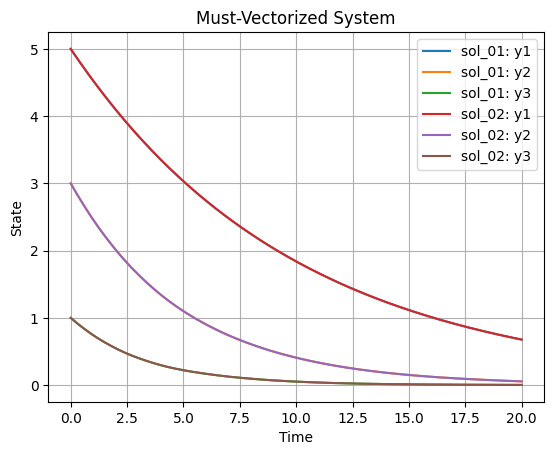

In [21]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

# Vectorized-only ODE function
def vectorized_decay(t, Y):
    # Expect Y.shape == (3, m) — must fail if Y is (3,)
    if Y.ndim != 2:
        raise ValueError("This function only supports vectorized (2D) input.")
    
    decay_rates = np.array([[0.1], [0.2], [0.3]])  # shape (3, 1)
    return -decay_rates * Y  # broadcasted over all m columns

# Vectorized-only ODE function
def not_vectorized_decay(t, Y):
    # Expect Y.shape == (3, m) — must fail if Y is (3,)
    if Y.ndim != 1:
        raise ValueError("This function only supports vectorized (2D) input.")
    
    decay_rates = [0.1, 0.2, 0.3]
    return -np.multiply(decay_rates, Y)

# Initial state
y0 = [5.0, 3.0, 1.0]

# Time points
t_eval = np.linspace(0, 20, 200)

# Solve (must use vectorized=True)
start_sol_1 = time.time()
sol_01 = solve_ivp(vectorized_decay, (0, 20), y0, t_eval=t_eval, vectorized=True, rtol=1e-2, atol=1e-3, method='BDF')
duration_01 = time.time() - start_sol_1
print('vectorized solution running time: ', duration_01)

start_sol_2 = time.time()
sol_02 = solve_ivp(not_vectorized_decay, (0, 20), y0, t_eval=t_eval, vectorized=False, rtol=1e-2, atol=1e-3, method='BDF')
                #    method='Radau') # Default is vectorized=False
duration_02 = time.time() - start_sol_2
print('non vectorized solution running time: ', duration_02)

# Plotting
plt.plot(sol_01.t, sol_01.y[0], label='sol_01: y1')
plt.plot(sol_01.t, sol_01.y[1], label='sol_01: y2')
plt.plot(sol_01.t, sol_01.y[2], label='sol_01: y3')

plt.plot(sol_02.t, sol_02.y[0], label='sol_02: y1')
plt.plot(sol_02.t, sol_02.y[1], label='sol_02: y2')
plt.plot(sol_02.t, sol_02.y[2], label='sol_02: y3')

plt.xlabel('Time')
plt.ylabel('State')
plt.title('Must-Vectorized System')
plt.grid(True)
plt.legend()
plt.show()


### `first_step` and `max_step`

#### `first_step` : *float or None*, optional  
- The initial time step used by the solver.
- If `None` (default), the solver chooses it automatically based on `y0`, `t_span`, and tolerances.
- Use this if you want to force a specific resolution at the start (e.g., capturing steep dynamics).

#### `max_step` : *float*, optional  
- The maximum allowed step size.
- Default is `np.inf`, so the solver chooses freely.
- Use this to prevent the solver from "jumping over" important features (e.g., short pulses or events).


## Summary Table
| Parameter     | Description |
|---------------|-------------|
| `fun`         | ODE system as function `f(t, y)` |
| `t_span`      | Interval `(t0, tf)` to solve on |
| `y0`          | Initial condition(s) |
| `method`      | Solver algorithm (RK, BDF, etc.) |
| `t_eval`      | Time points to evaluate solution |
| `rtol`, `atol`| Tolerances for adaptive step size |
| `vectorized`  | Assume function supports vector inputs |


### Stiff Problem Parameters - Jacobian-related

| Parameter        | Applies To              | Stiff Solvers Only? | Description                                                                             |
| ---------------- | ----------------------- | ------------------- | --------------------------------------------------------------------------------------- |
| `jac`            | `BDF`, `Radau`, `LSODA` | ✅ Yes               | Jacobian matrix $J = \partial f / \partial y$ — improves solver efficiency and accuracy |
| `jac_sparsity`   | `BDF`, `Radau`          | ✅ Yes               | Structure of the Jacobian for sparse systems — speeds up large stiff problems           |
| `lband`, `uband` | `BDF`, `Radau`          | ✅ Yes               | Specifies that the Jacobian is banded, helps solver optimize storage & computation      |
